This jupyter notebook will explore trends in pre and post disturbance SWE by running a timeseries analysis for:
- SWE pre and post fire, compared temporally for values before and after the fire
- SWE pre and post fire, compared spatially to nearby fire locations (to try to take annual precipitation into account)
- SWE pre and post fire, compared for 5 years after fire
It will also display confidence intervals for each trend analysis run.
Lastly, we will also look at burn severity by comparing trends in SWE between sites with differing burn severities 

In [1]:
import sys

In [32]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats
from scipy.interpolate import interp1d
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from SNOTEL_splitter import splitFireSNOTEL
%matplotlib inline

In [33]:
import matplotlib as mpl
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk') 

Before running this at all locations, we will start with looking at one: Harts Pass

In [227]:
site = 'Sentinel Butte'
paired = 'Gold Axe Camp'
years = 3
# fire locations
fire_sites = {'Sentinel Butte':'Gold Axe Camp', # apparent postive/null
              'Grouse Camp':'Trough', # apparent negative
              'Harts Pass':'Lyman Lake', # apparent positive/null
              'Three Creeks Meadow': 'Salt Creek Falls', # apparent negative/null
              'Pope Ridge': 'Blewett Pass'}# apparent negative/null
# fire_sites = {'Sentinel Butte':'Gold Axe Camp', 
#               'Grouse Camp':'Trough', 
#               'Harts Pass':'Rainy Pass', # apparent postive/null
#               'Three Creeks Meadow': 'Irish Taylor', # apparent postive/null
#               'Pope Ridge': 'Trinity'} # apparent postive/null
filepath = r'C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565_project\data\fire_sites'
disruption_dates = pd.read_excel(os.path.join(filepath,'snotel_fire_data.xlsx'))
variable = 'swe'
def getSites(site, paired, fire_dict=fire_sites, filepath=filepath, disruption_dates=disruption_dates, variable=variable,postyrs=5):
    """getSites will return filtered dataframes for the inputed site and its paired site, and can filter 
       to particular number of years after the disturbance

    Args:
        site (str): site of interest
        paired (str): paired site
        fire_dict (dict): dict containing sites and paired sites. Defaults to fire_sites.
        filepath (str): Path to data location. Defaults to filepath.
        disruption_dates (df): df containing fire start date and intensity values. Defaults to disruption_dates.
        variable (str): swe or depth. Can be adapted set of variables of interest. Defaults to swe.
        postyrs (int, optional): number of years after distrubance to report data. Defaults to 5.

    Returns:
        [type]: [description]
    """
    df_b, df_a = splitFireSNOTEL(site,fire_sites,variable,disruption_dates,filepath)
    df_paired_b, df_paired_a = splitFireSNOTEL(paired,fire_sites,variable,disruption_dates,filepath)
    fire_year = min(df_a.index.year)
    if postyrs != 'max':
        df_a = df_a.loc[dt.date(fire_year,10,1):dt.date(fire_year+postyrs,9,30)]
        df_paired_a = df_paired_a.loc[dt.date(fire_year,10,1):dt.date(fire_year+postyrs,9,30)]
    print('Filtering to {} years after fire...'.format(postyrs))
    print('Done!')
    return df_b, df_a, df_paired_b, df_paired_a

In [228]:
df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, postyrs=years)

Sentinel Butte
Sentinel Butte
Filtering to 3 years after fire...
Done!


In [229]:
def boxplotSWE(ax, before, after, paired_before, paired_after,postyrs=5):
    # remove 0s
    pltlabels = ['pre-fire', '{} years\npost-fire'.format(postyrs),'pre-fire paired', '{} years\npost-fire paired'.format(postyrs)]
    ax.boxplot([df_b[df_b['SNOTEL:WTEQ_D']!=0]['SNOTEL:WTEQ_D'].dropna(),
                df_a[df_a['SNOTEL:WTEQ_D']!=0]['SNOTEL:WTEQ_D'].dropna(),
                df_paired_b[df_paired_b['SNOTEL:WTEQ_D']!=0]['SNOTEL:WTEQ_D'].dropna(),
                df_paired_a[df_paired_a['SNOTEL:WTEQ_D']!=0]['SNOTEL:WTEQ_D'].dropna()], labels = pltlabels)
    ax.set_xlabel(site+'                                   '+paired, fontdict={'weight':'bold'})
    ax.set_ylabel('SWE [mm]')
    ax.set_title('SWE box plots for {} and {}'.format(site, paired))
    return ax


In [230]:
def plotSWE(ax, before, after, site, paired=False):
    """plotSWE will plot mean SWE prior to the disturbance event against post disturbance SWE.

    Args:
        ax (axis): axis for plotting purposes
        before (df): pre-disturbance df
        after (df): post-distrubance df
        site (str): site name
        paired (bool, optional): If location is paired, set to true. Defaults to False.
    """
    for i,year in enumerate(after.index.year.unique()):
        # water_year_df_b = df_b.loc[dt.date(year,10,1):dt.date(year+1,9,30)].reindex()
        water_year_df_a = after.loc[dt.date(year,10,1):dt.date(year+1,9,30)].reset_index()
        # plt.plot(water_year_df_b.index, water_year_df_b['SNOTEL:WTEQ_D'])
        ax.plot(water_year_df_a.index, water_year_df_a['SNOTEL:WTEQ_D'], lw=1, label = '{} yr post-fire'.format(i))
    mean_swe = []
    minyear = min(before.index.year.unique())
    maxyear = max(before.index.year.unique())
    for i,date in enumerate(before.loc[dt.date(minyear,10,1):dt.date(minyear+1,9,30)].index.date):
        if i == 0:
            print('Start date: '+str(date))
        daily_mean_swe = before[(before.index.month == date.month) & (before.index.day == date.day)]['SNOTEL:WTEQ_D'].mean()
        mean_swe.append(daily_mean_swe)
    mean_swe = pd.Series(mean_swe,name='mean_swe')
    mean_swe.plot(ax=ax,label='{}-{}\nMean SWE'.format(minyear,maxyear))
    ax.set_xlabel('Day of Water Year')
    ax.set_ylabel('SWE [mm]')
    if site == 'Harts Pass' or 'Lyman Lake':
        ax.set_ylim(0,100)
    else:
        ax.set_ylim(0,45)
    if paired is True:
        site = 'Paired Location: '+site
    ax.set_title('Mean SWE and Post-Disturbance\n{}'.format(site))
    return ax

    

Sentinel Butte
Sentinel Butte
Filtering to 3 years after fire...
Done!
Start date: 2003-10-01
Start date: 2010-10-01
Grouse Camp
Grouse Camp
Filtering to 3 years after fire...
Done!
Start date: 1982-10-01
Start date: 1978-10-01
Harts Pass
Harts Pass
Filtering to 3 years after fire...
Done!
Start date: 1982-10-01
Start date: 1979-10-01
Three Creeks Meadow
Three Creeks Meadow
Filtering to 3 years after fire...
Done!
Start date: 1980-10-01
Start date: 1980-10-01
Pope Ridge
Pope Ridge
Filtering to 3 years after fire...
Done!
Start date: 1981-10-01
Start date: 1981-10-01


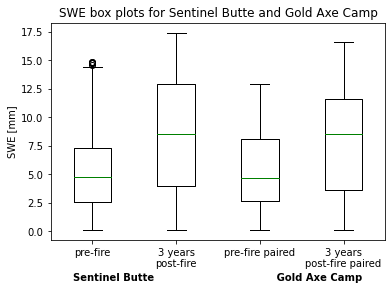

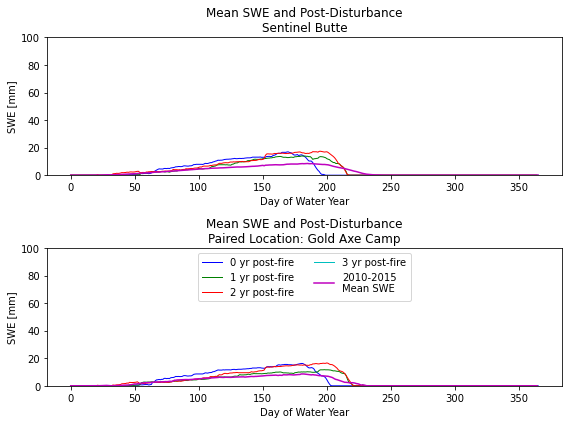

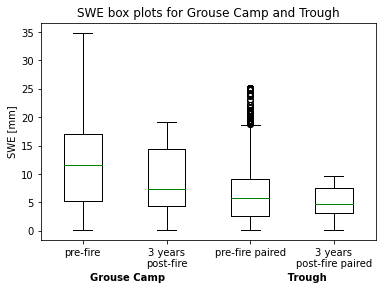

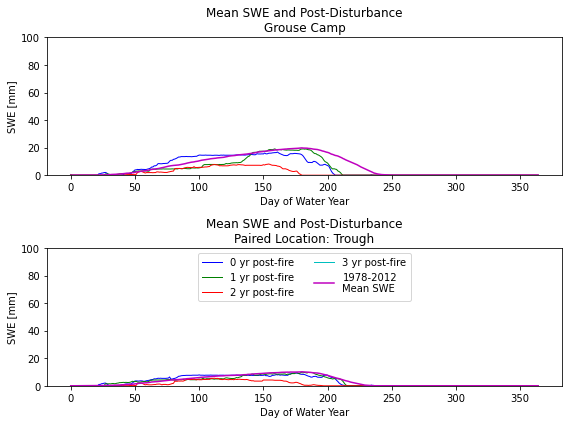

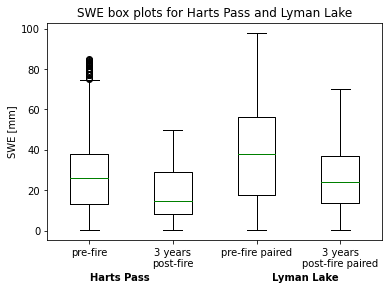

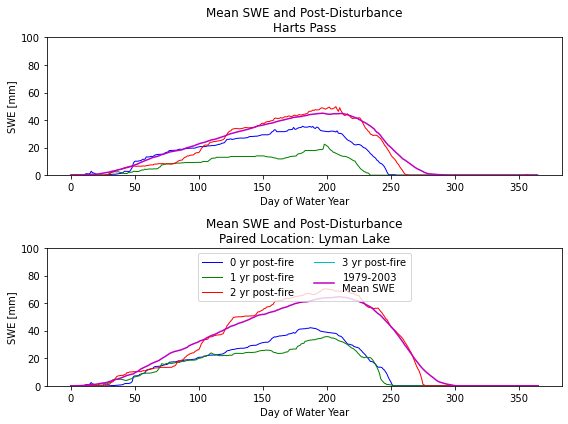

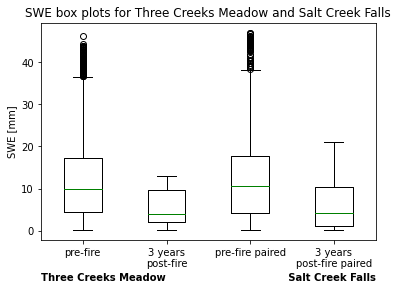

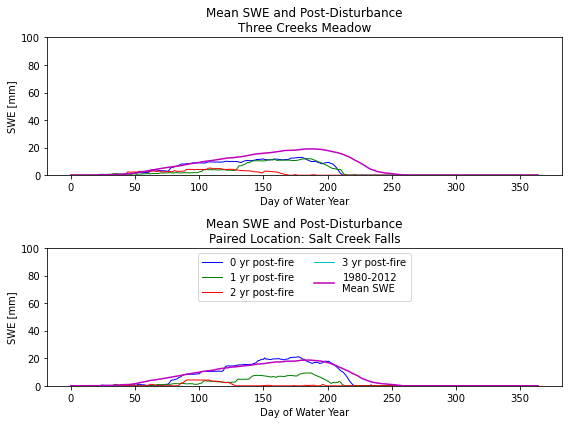

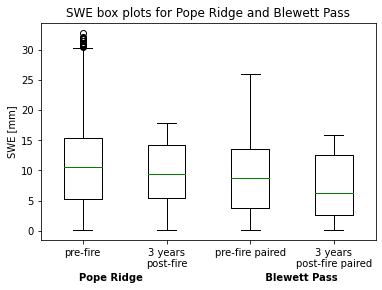

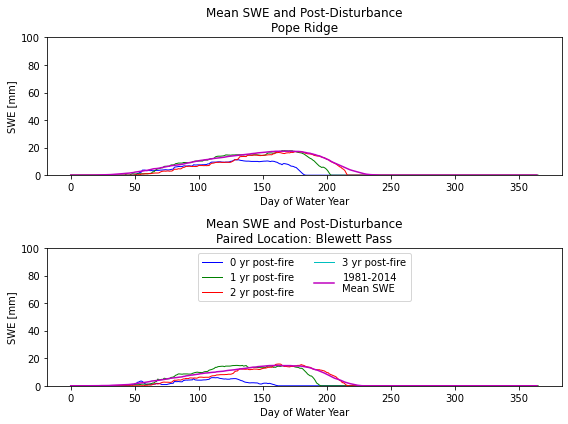

In [231]:

for i,(site,paired) in enumerate(fire_sites.items()):
    df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, postyrs=years)
    fig1, ax = plt.subplots()
    boxplotSWE(ax,df_b, df_a, df_paired_b, df_paired_a, postyrs=years)
    fig2, (ax1,ax2) = plt.subplots(2,figsize=(8,6), tight_layout=True)
    plotSWE(ax1,df_b,df_a,site)
    plotSWE(ax2,df_paired_b,df_paired_a,paired,paired=True)
    ax2.legend(loc='upper center',ncol=2)

Sentinel Butte
Sentinel Butte
Filtering to 3 years after fire...
Done!
Grouse Camp
Grouse Camp
Filtering to 3 years after fire...
Done!
Harts Pass
Harts Pass
Filtering to 3 years after fire...
Done!
Three Creeks Meadow
Three Creeks Meadow
Filtering to 3 years after fire...
Done!
Pope Ridge
Pope Ridge
Filtering to 3 years after fire...
Done!


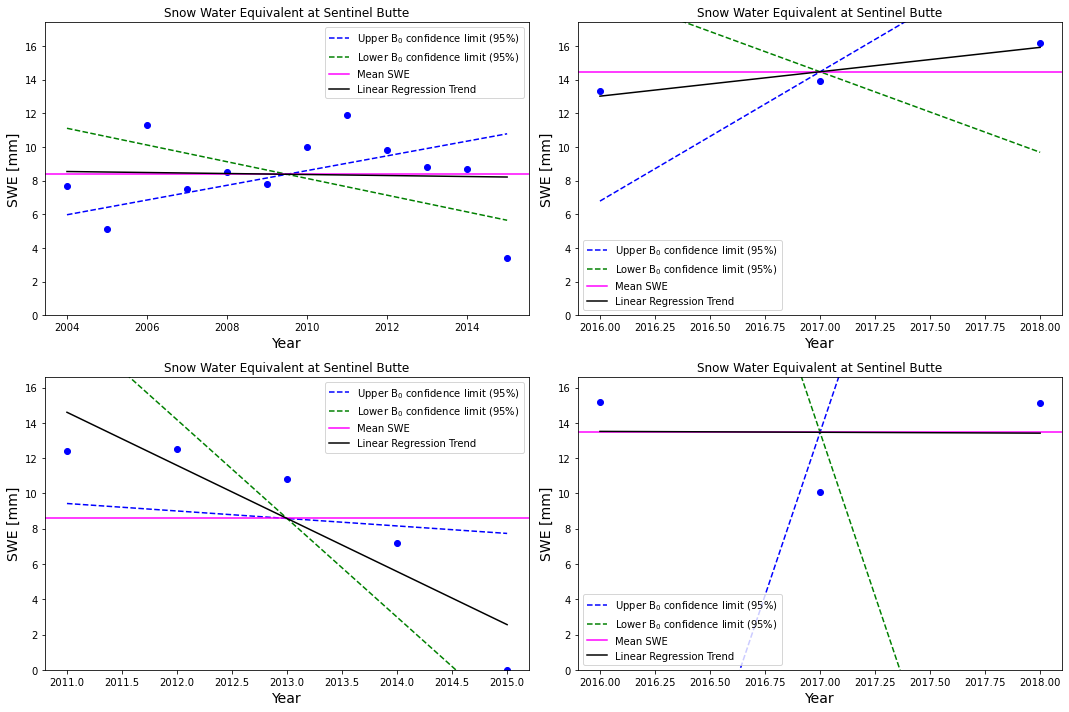

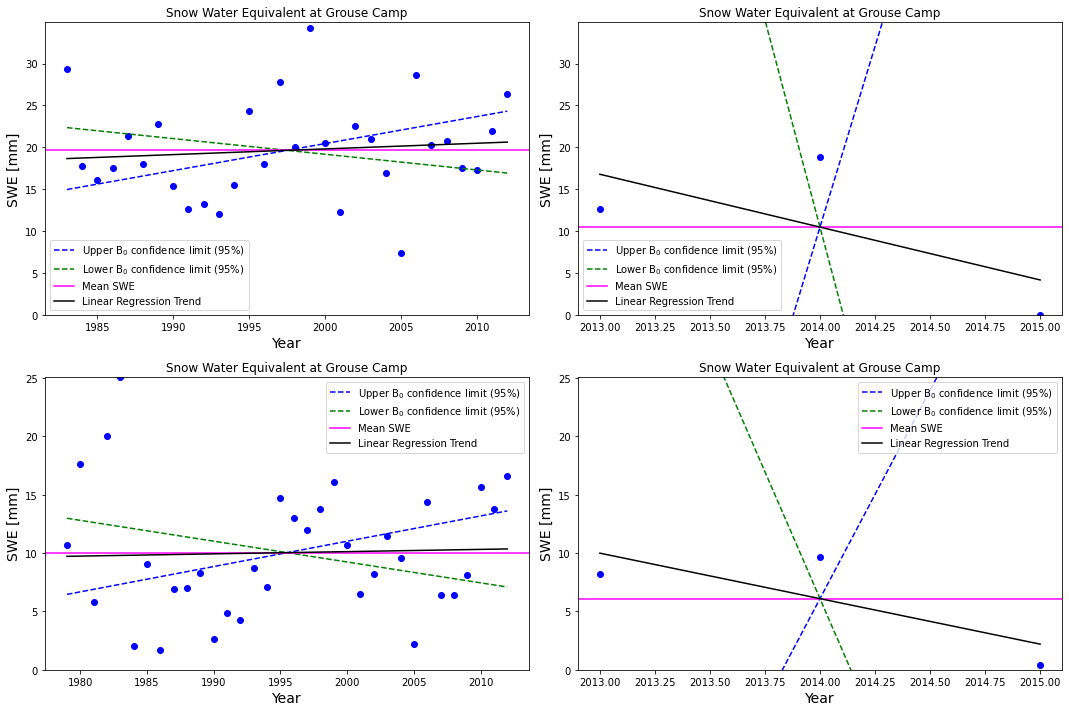

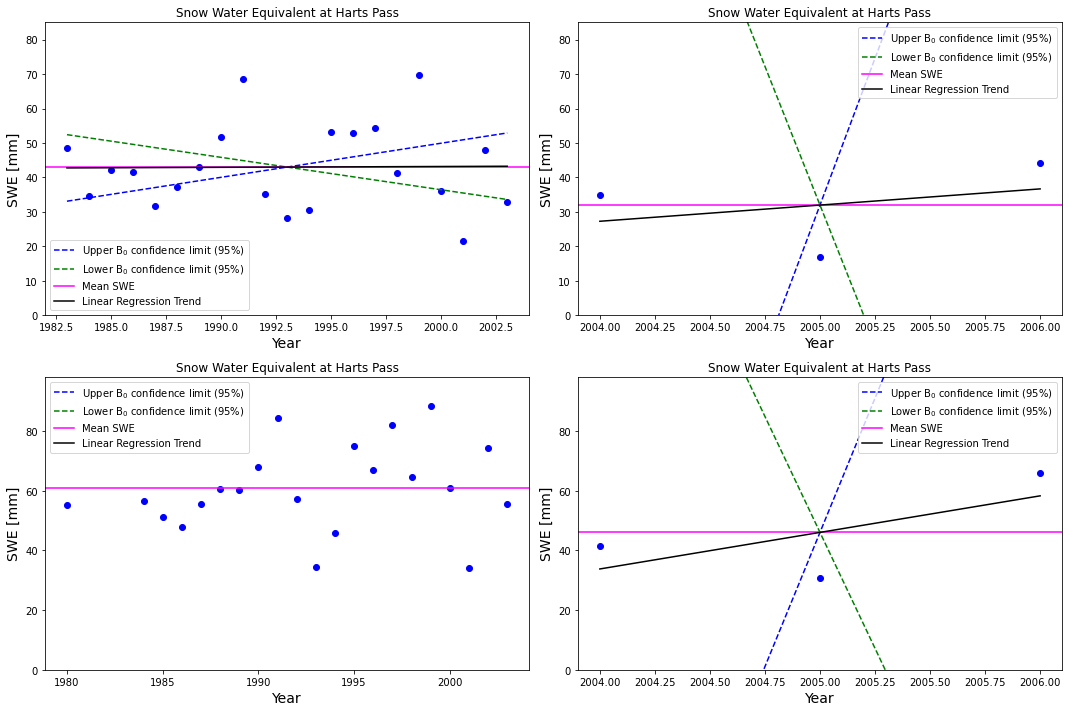

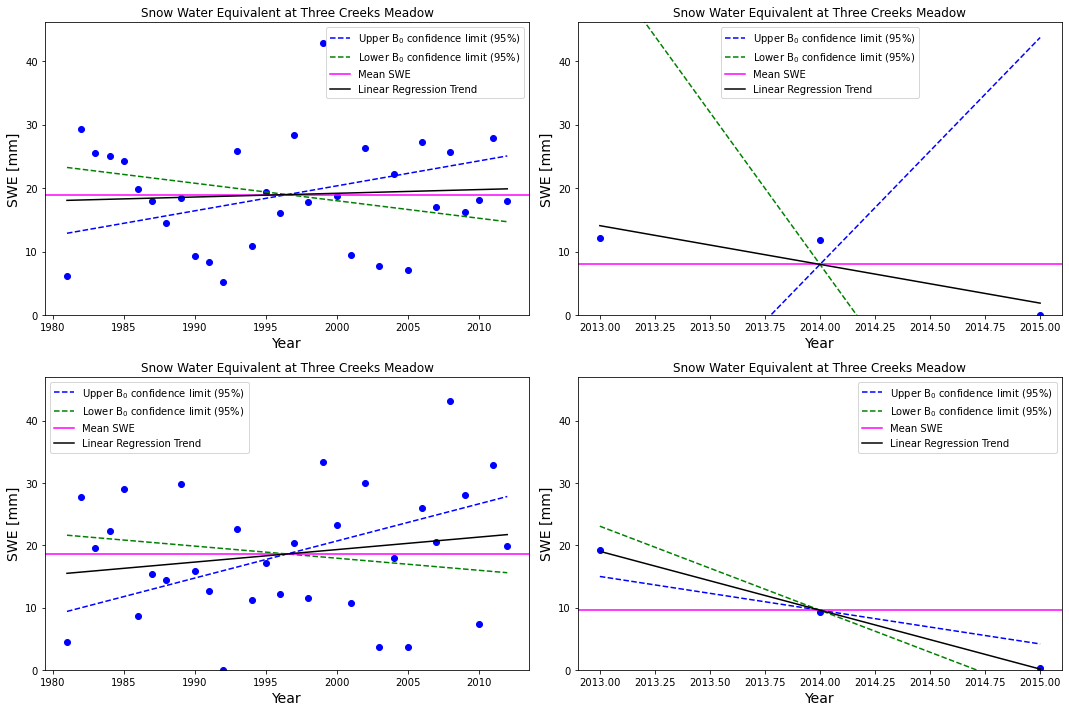

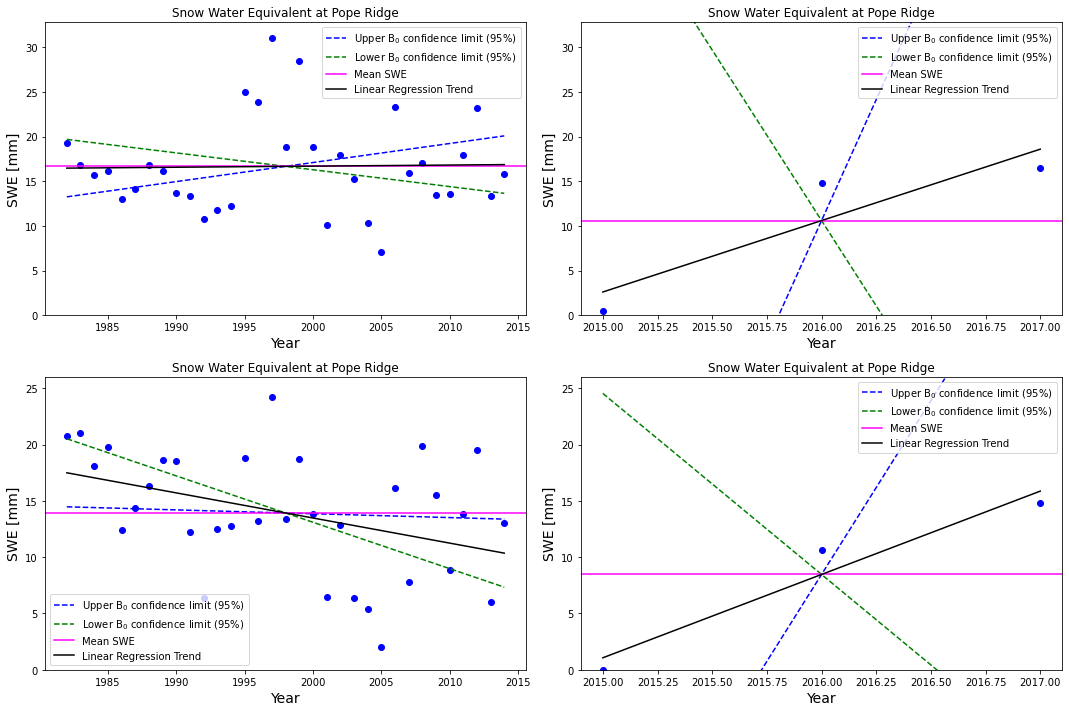

In [232]:
for (site,paired) in fire_sites.items():
        fig, axs = plt.subplots(2,2, figsize=(15,10),tight_layout=True)
        axs = axs.flatten()
        df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, postyrs=years)
        for i,df in enumerate([df_b, df_a, df_paired_b, df_paired_a]):
                if i == 2 or i ==3:
                        max_swe = max(df_paired_b['SNOTEL:WTEQ_D'].max(), df_paired_a['SNOTEL:WTEQ_D'].max(),)
                else:
                        max_swe=max(df_b['SNOTEL:WTEQ_D'].max(),df_a['SNOTEL:WTEQ_D'].max())
                ax = axs[i]
                # use the linear regression function
                swe_b = df[(df.index.month==4) & (df.index.day==1)]
                slope, intercept, rvalue, pvalue, stderr = stats.linregress(swe_b.index.year, swe_b['SNOTEL:WTEQ_D'])
                # Create points for the regression line
                x_before = np.linspace(swe_b.index.year.min(), swe_b.index.year.max(), swe_b.index.year.size) # x coordinates from min and max values 
                y_before = slope * x_before + intercept # y coordinates using the slope and intercept from our linear regression
                # compute SST for col
                sst_x = np.sum( (swe_b.index.year - np.mean(swe_b.index.year))**2 )
                # Compute the standard error
                sigma = stderr * np.sqrt(sst_x)
                r_squared = rvalue**2
                # conf interval calculations
                sB1 = sigma/np.sqrt(sst_x)
                # t-value for alpha/2 with n-2 degrees of freedom
                alpha = 0.05
                n = len(x_before)
                dof = n - 2
                t = stats.t.ppf(1-alpha/2, dof)
                # compute upper and lower b1 limits
                B1_upper = slope + t * sB1
                B1_lower = slope - t * sB1
                # compute corresponding b0s
                B0_upper = swe_b['SNOTEL:WTEQ_D'].mean() - B1_upper*np.mean(swe_b.index.year)
                B0_lower = swe_b['SNOTEL:WTEQ_D'].mean() - B1_lower*np.mean(swe_b.index.year)
                # Plot the upper and lower confidence limits for the standard error of the gradient (slope)
                ax.plot([x_before.min(), x_before.max()],
                        [B0_upper + B1_upper*swe_b.index.year.min(), B0_upper + B1_upper*swe_b.index.year.max()] ,
                        '--b',
                        label='Upper B$_0$ confidence limit (95%)')
                ax.plot([x_before.min(), x_before.max()],
                        [B0_lower + B1_lower*swe_b.index.year.min(), B0_lower + B1_lower*swe_b.index.year.max()] ,
                        '--g',
                        label='Lower B$_0$ confidence limit (95%)')
                # plot up other items
                ax.axhline(swe_b['SNOTEL:WTEQ_D'].mean(),color='magenta', label='Mean SWE')
                ax.plot(x_before,y_before,'k-',label='Linear Regression Trend')
                ax.scatter(swe_b.index.year,swe_b['SNOTEL:WTEQ_D'])
                ax.set_ylim(0,max_swe)
                ax.set_xlabel('Year', size=14)
                ax.set_ylabel('SWE [mm]', size=14)
                ax.legend()
                ax.set_title('Snow Water Equivalent at {}'.format(site))

In [233]:
import seaborn as sns
import statsmodels.formula.api as smf

Sentinel Butte
Sentinel Butte
Filtering to 3 years after fire...
Done!
1.2050000000000036
Grouse Camp
Grouse Camp
Filtering to 3 years after fire...
Done!
-5.205882352941175
Harts Pass
Harts Pass
Filtering to 3 years after fire...
Done!
3.857142857142833
Three Creeks Meadow
Three Creeks Meadow
Filtering to 3 years after fire...
Done!
-1.9604166666666707
Pope Ridge
Pope Ridge
Filtering to 3 years after fire...
Done!
-0.6121212121212185


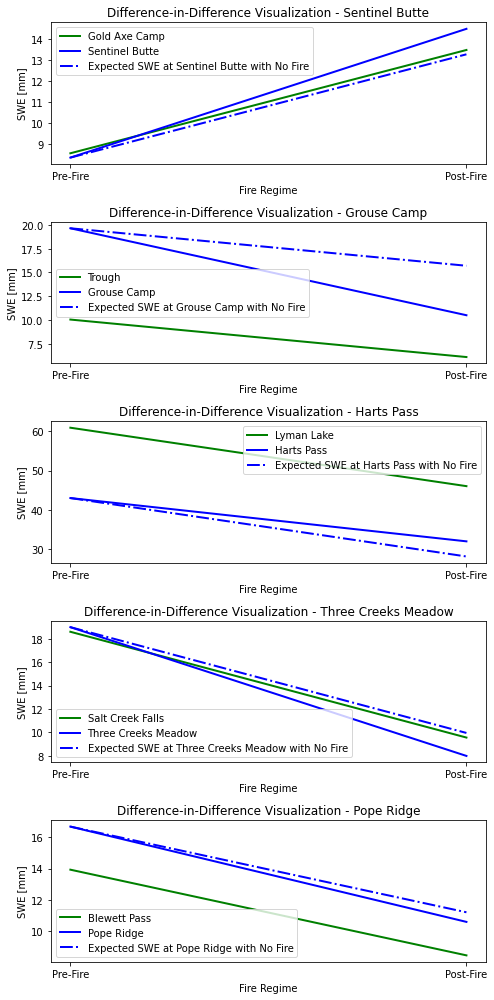

In [234]:
fig, axs = plt.subplots(5,figsize=(7,14),tight_layout=True)
for i,(site,paired) in enumerate(fire_sites.items()):
        
        df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, postyrs=years)

        avg_4_1_swe_b = df_b[(df_b.index.month==4) & (df_b.index.day==1)]['SNOTEL:WTEQ_D'].mean()
        avg_4_1_swe_b_paired = df_paired_b[(df_paired_b.index.month==4) & (df_paired_b.index.day==1)]['SNOTEL:WTEQ_D'].mean()
        avg_4_1_swe_a = df_a[(df_a.index.month==4) & (df_a.index.day==1)]['SNOTEL:WTEQ_D'].mean()
        avg_4_1_swe_a_paired = df_paired_a[(df_paired_a.index.month==4) & (df_paired_a.index.day==1)]['SNOTEL:WTEQ_D'].mean()

        diff_in_diff = (avg_4_1_swe_a-avg_4_1_swe_b)-(avg_4_1_swe_a_paired-avg_4_1_swe_b_paired)
        print(diff_in_diff)

        axs[i].plot(['Pre-Fire', "Post-Fire"], [avg_4_1_swe_b_paired, avg_4_1_swe_a_paired], c= 'g',label=paired, lw=2)
        axs[i].plot(["Pre-Fire", "Post-Fire"], [avg_4_1_swe_b, avg_4_1_swe_a],c= 'b', label=site, lw=2)

        axs[i].plot(["Pre-Fire", "Post-Fire"], [avg_4_1_swe_b, avg_4_1_swe_b+(avg_4_1_swe_a_paired-avg_4_1_swe_b_paired)],
                label="Expected SWE at {} with No Fire".format(site), lw=2, color="b", ls="-.")
        axs[i].legend()
        axs[i].set_xlabel('Fire Regime')
        axs[i].set_ylabel('SWE [mm]')
        axs[i].set_title('Difference-in-Difference Visualization - {}'.format(site))

In [235]:
diff_in_diff_results = {}
for i,(site,paired) in enumerate(fire_sites.items()):
    df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, postyrs=years)
    df1 = df_b[(df_b.index.month==4) & (df_b.index.day==1)].reset_index()
    df1 = df1[['datetime','SNOTEL:WTEQ_D']].dropna()
    df1['pre_post'] = 0
    df1['original'] = 1

    df2 = df_paired_b[(df_paired_b.index.month==4) & (df_paired_b.index.day==1)].reset_index()
    df2 = df2[['datetime','SNOTEL:WTEQ_D']].dropna()
    df2['pre_post'] = 0
    df2['original'] = 0

    df3 = df_a[(df_a.index.month==4) & (df_a.index.day==1)].reset_index()
    df3 = df3[['datetime','SNOTEL:WTEQ_D']].dropna()
    df3['pre_post'] = 1
    df3['original'] = 1

    df4 = df_paired_a[(df_paired_a.index.month==4) & (df_paired_a.index.day==1)].reset_index()
    df4 = df4[['datetime','SNOTEL:WTEQ_D']].dropna()
    df4['pre_post'] = 1
    df4['original'] = 0

    df = pd.concat([df1,df2,df3,df4])
    df = df.rename(columns = {'SNOTEL:WTEQ_D':'April1SWE'})
    results = smf.ols("April1SWE ~ original*pre_post",data=df).fit().summary()
    print(results)
    results_as_html = results.tables[1].as_html()
    diff_in_diff_ols = pd.read_html(results_as_html,header=0, index_col=0)[0]
    diff_in_diff_results[site] = diff_in_diff_ols
    post_fire_difference = diff_in_diff_ols.loc['original:pre_post']['coef']
    post_fire_stderror = diff_in_diff_ols.loc['original:pre_post']['std err']

    print('Post fire influence on SWE at {}: {} mm'.format(site,post_fire_difference))
    print('Post fire influence on SWE + standard error: {} mm'.format(post_fire_difference+post_fire_stderror))
    print('Post fire influence on SWE - standard error: {} mm'.format(post_fire_difference-post_fire_stderror))

Sentinel Butte
Sentinel Butte
Filtering to 3 years after fire...
Done!
                            OLS Regression Results                            
Dep. Variable:              April1SWE   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     4.459
Date:                Wed, 17 Nov 2021   Prob (F-statistic):             0.0156
Time:                        22:57:13   Log-Likelihood:                -57.222
No. Observations:                  23   AIC:                             122.4
Df Residuals:                      19   BIC:                             127.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [222]:
diff_in_diff_results

{'Sentinel Butte':                     coef  std err      t  P>|t|  [0.025  0.975]
 Intercept          8.580    1.520  5.644  0.000   5.436  11.724
 original          -0.205    1.809 -0.113  0.911  -3.948   3.538
 pre_post           2.520    2.150  1.172  0.253  -1.927   6.967
 original:pre_post  1.685    2.810  0.600  0.555  -4.127   7.497,
 'Grouse Camp':                       coef  std err      t  P>|t|  [0.025  0.975]
 Intercept          10.0441    1.018  9.862  0.000   8.013  12.075
 original            9.6059    1.488  6.458  0.000   6.639  12.573
 pre_post            0.0559    2.844  0.020  0.984  -5.617   5.729
 original:pre_post  -4.8659    4.040 -1.205  0.232 -12.923   3.191,
 'Harts Pass':                       coef  std err       t  P>|t|  [0.025  0.975]
 Intercept          60.9238    2.988  20.391  0.000  54.917  66.931
 original          -17.9238    4.225  -4.242  0.000 -26.419  -9.428
 pre_post           -8.7638    6.813  -1.286  0.205 -22.462   4.935
 original:pre_post 

Next, we'll do a similar analysis but for snow melt out dates